In [20]:
import numpy as np 
import pysindy as ps 
import pandas as pd 
import random
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from numpy import genfromtxt

from matplotlib import style
style.use('seaborn-white')

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [21]:
df = pd.read_csv('../../../Data/ASTAZERO/dataVehicle1.csv', header=None,low_memory=False, encoding='UTF-8')
df = df.rename(columns={0:"TIME",1:"LEAD_POS",2:"FOLLOW_POS",3:"LEAD_VEL",4:"FOLLOW_VEL",5:"LEAD_LENGTH"})
df = pd.DataFrame(df)
print(df)

         TIME      LEAD_POS    FOLLOW_POS  LEAD_VEL  FOLLOW_VEL  LEAD_LENGTH
0         1.0   4466.914835   4458.758374  0.021174    0.007862        5.196
1         1.1   4466.916899   4458.759248  0.020108    0.009621        5.196
2         1.2   4466.918861   4458.760291  0.019126    0.011245        5.196
3         1.3   4466.920728   4458.761491  0.018225    0.012739        5.196
4         1.4   4466.922510   4458.762833  0.017404    0.014105        5.196
...       ...           ...           ...       ...         ...          ...
11752  1176.2  27440.670420  27431.138280  0.042988    0.011987        5.196
11753  1176.3  27440.674690  27431.139230  0.042337    0.006957        5.196
11754  1176.4  27440.678880  27431.139640  0.041571    0.001273        5.196
11755  1176.5  27440.682990  27431.139710  0.040687    0.000000        5.196
11756  1176.6  27440.687010  27431.139710  0.039682    0.000000        5.196

[11757 rows x 6 columns]


In [22]:
############ Converting Python DataFrames to Numpy Arrays ############

t = np.asarray(df["TIME"])
leadPos = np.asarray(df['LEAD_POS']) # Leading vehicle position 
followPos = np.asarray(df['FOLLOW_POS']) # Follow vehicle position 
vlead = np.asarray(df['LEAD_VEL']) # Leading vehicle velocity
v = np.asarray(df['FOLLOW_VEL']) # Follow vehicle velocity
leadLen = np.asarray(df["LEAD_LENGTH"]) # lead vehicle length 
leadVehLen = df.iat[0,5]
s = leadPos - followPos - leadLen[0]
#dt = t[1] - t[0]
dt = 0.1

sCheck = s<=0   # making sure that it is positive 
vehLen = leadLen!=5.196000000000001  # check if all the vehicles have the same length 
print(np.count_nonzero(vehLen)) # count the number of True 
print(np.count_nonzero(sCheck)) # count number of True 

statTrajec = 0
endTrajec = -1

#t = np.linspace(0, 188.8, 1888, endpoint=False) # 288.4 for JIANG # 188.9 for NAPOLI
t = t[statTrajec:endTrajec]

# Without Scaling 
v = v[statTrajec:endTrajec]
s = s[statTrajec:endTrajec]
vlead = vlead[statTrajec:endTrajec]

followPos = followPos[statTrajec:endTrajec]
leadPos = leadPos[statTrajec:endTrajec]

############ Calculating the Follower Derivative ############

FD = ps.SmoothedFiniteDifference()
v_p = FD(v, t) #HDWY Derivative #(670,1)
v_p = np.reshape(v_p, (v.size,)) #(670,)
  
min_acc = np.min(v_p)  # min acceleration 
max_acc = np.max(v_p)  # max acceleration 

0
0


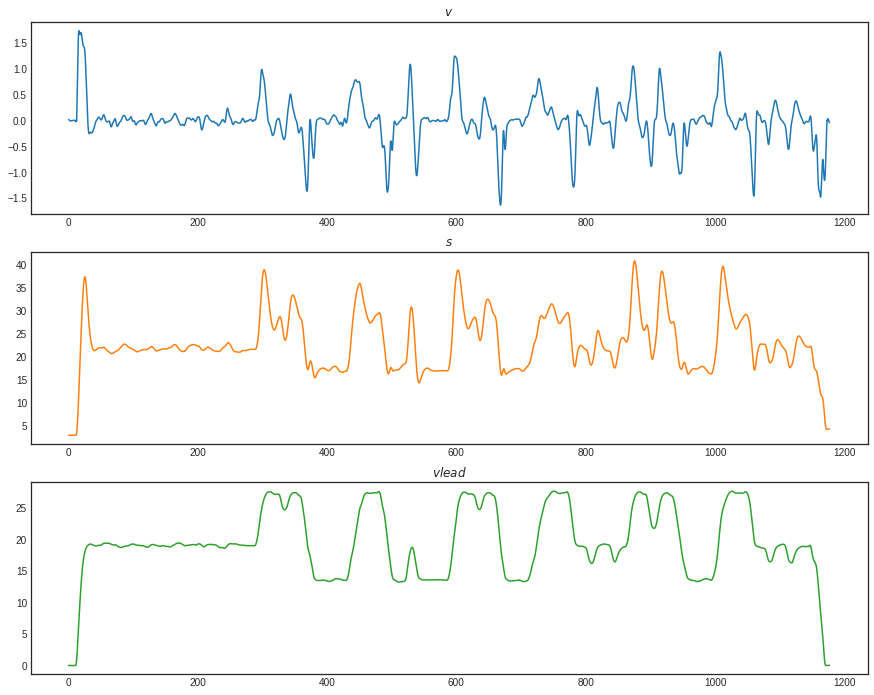

In [23]:
# Plotting the data
# plt.rc('font', size=10)
fig, (ax1,ax2,ax3) = plt.subplots(3)

statTraj = 0 #7000
endsTraj = -1 #8900

fig.set_figheight(12)
fig.set_figwidth(15)
#ax1.plot(t[vehCon][statTraj:endsTraj], v[vehCon][statTraj:endsTraj])
ax1.plot(t[statTraj:endsTraj], v_p[statTraj:endsTraj])
ax1.set_title('$v$')
ax2.plot(t[statTraj:endsTraj], s[statTraj:endsTraj], 'tab:orange')
ax2.set_title('$s$')
ax3.plot(t[statTraj:endsTraj], vlead[statTraj:endsTraj], 'tab:green')
ax3.set_title('$vlead$')

plt.show()

# LSTM

In [24]:
st_Traj = 0
en_Traj = 9405 #1511 #9405 # 2307

X_train = np.stack((v[st_Traj:en_Traj],s[st_Traj:en_Traj],vlead[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

#Y_train = np.stack((v_p[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)
#Y_train = np.stack((v[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)
Y_train = np.stack((s[st_Traj:en_Traj],t[st_Traj:en_Traj]), axis=1)

X_prior = np.stack((v,s,vlead,t), axis=1)  # For plotting in this section 

#X_Full = np.stack((v,s,vlead,v_p), axis=1)
#X_Full = np.stack((v,s,vlead,v), axis=1)
X_Full = np.stack((v,s,vlead,s), axis=1)

np.savetxt("lstm_data3.csv", X_Full, delimiter=",")

In [25]:
df_lstm = pd.read_csv("lstm_data3.csv", header=None,low_memory=False, encoding='UTF-8')
df_lstm = df_lstm.rename(columns={0:"FOLLOW_VEL",1:"HEADWAY",2:"LEAD_VEL",3:"FOLLOW_ACC"})
df_lstm = pd.DataFrame(df_lstm)
df_lstm

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,0.007862,2.960461,0.021174,2.960461
1,0.009621,2.961651,0.020108,2.961651
2,0.011245,2.962570,0.019126,2.962570
3,0.012739,2.963237,0.018225,2.963237
4,0.014105,2.963677,0.017404,2.963677
...,...,...,...,...
11751,0.016394,4.333230,0.043526,4.333230
11752,0.011987,4.336140,0.042988,4.336140
11753,0.006957,4.339460,0.042337,4.339460
11754,0.001273,4.343240,0.041571,4.343240


In [26]:
target = 'FOLLOW_ACC'
features = list(df_lstm.columns.difference([target]))

past_seq = 1
df_lstm[target] = df_lstm[target].shift(-past_seq)
df_lstm = df_lstm.iloc[:-past_seq]
df_lstm

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,0.007862,2.960461,0.021174,2.961651
1,0.009621,2.961651,0.020108,2.962570
2,0.011245,2.962570,0.019126,2.963237
3,0.012739,2.963237,0.018225,2.963677
4,0.014105,2.963677,0.017404,2.963907
...,...,...,...,...
11750,0.020205,4.330690,0.043955,4.333230
11751,0.016394,4.333230,0.043526,4.336140
11752,0.011987,4.336140,0.042988,4.339460
11753,0.006957,4.339460,0.042337,4.343240


In [27]:
test_start = en_Traj
df_lstm_train = df_lstm.loc[:test_start].copy()
df_lstm_test = df_lstm.loc[test_start:].copy()

In [28]:
target_mean = df_lstm_train[target].mean()
target_stdev = df_lstm_train[target].std()

vel_mean = df_lstm_train['FOLLOW_VEL'].mean()
vel_stdev = df_lstm_train['FOLLOW_VEL'].std()

headway_mean = df_lstm_train['HEADWAY'].mean()
headway_stdev = df_lstm_train['HEADWAY'].std()

for c in df_lstm_train.columns:
    mean = df_lstm_train[c].mean()
    stdev = df_lstm_train[c].std()

    df_lstm_train[c] = (df_lstm_train[c] - mean) / stdev
    df_lstm_test[c] = (df_lstm_test[c] - mean) / stdev

In [29]:
df_lstm_train.head(11)

,FOLLOW_VEL,HEADWAY,LEAD_VEL,FOLLOW_ACC
0,-3.565800,-3.336137,-3.710998,-3.338216
1,-3.565485,-3.335942,-3.711197,-3.338066
2,-3.565194,-3.335791,-3.711380,-3.337956
3,-3.564926,-3.335681,-3.711548,-3.337884
4,-3.564681,-3.335609,-3.711701,-3.337846
5,-3.564458,-3.335572,-3.711840,-3.337839
6,-3.564257,-3.335565,-3.711965,-3.337860
7,-3.564076,-3.335586,-3.712077,-3.337906
8,-3.563916,-3.335632,-3.712176,-3.337974
9,-3.563775,-3.335700,-3.712264,-3.338062


In [24]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [25]:
#i = 0
#sequence_length = 10

#train_dataset = SequenceDataset(
#    df_lstm_train,
#    target=target,
#    features=features,
#    sequence_length=sequence_length
#)

#X, y = train_dataset[i]
#print(X)
#print(y)

In [26]:
#train_loader = DataLoader(train_dataset, batch_size=3, shuffle=False)

#X, y = next(iter(train_loader))
#print(X.shape)
#print(X)

In [27]:
val_Traj = 8465 #2048 #8465 #1359
df_lstm_train_c = df_lstm_train.loc[:val_Traj].copy()
df_lstm_val_c = df_lstm_train.loc[val_Traj:].copy()
# df_lstm_test should remain same 

In [28]:
batch_size = 4  # 4
sequence_length = 5  # 5

train_dataset = SequenceDataset(
    df_lstm_train_c,
    target=target,
    features=features,
    sequence_length=sequence_length
)

val_dataset = SequenceDataset(
    df_lstm_val_c,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_lstm_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) # True before
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 5, 3])
Target shape: torch.Size([4])


In [29]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_feat, hidden_units):
        super().__init__()
        self.num_feat = num_feat  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 3 # IT WAS 1 BEFORE

        self.lstm = nn.LSTM(
            input_size=num_feat,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [30]:
learning_rate = 5e-5
num_hidden_units = 200 #24 before

model = ShallowRegressionLSTM(num_feat=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Just run above this and then load the model. You have to run this everytime.

In [42]:
for parameter in model.parameters():
    print(parameter.shape)
sum(p.numel() for p in model.parameters() if p.requires_grad)    

torch.Size([800, 3])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([800, 200])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([800, 200])
torch.Size([800, 200])
torch.Size([800])
torch.Size([800])
torch.Size([1, 200])
torch.Size([1])


807401

In [43]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def val_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Val. loss: {avg_loss}")

In [44]:
print("Untrained test\n--------")
val_model(val_loader, model, loss_function)
print()

for ix_epoch in range(200):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_model(val_loader, model, loss_function)
    print()

Untrained test
--------
Val. loss: 0.47985839450890394

Epoch 0
---------
Train loss: 1.035745777566436
Val. loss: 0.4834232034840369

Epoch 1
---------
Train loss: 0.9428344600491628
Val. loss: 0.4685078562314349

Epoch 2
---------
Train loss: 0.7933565158855131
Val. loss: 0.4081456859092362

Epoch 3
---------
Train loss: 0.6708490700898322
Val. loss: 0.3330626533650292

Epoch 4
---------
Train loss: 0.5838083668560771
Val. loss: 0.2698700719261793

Epoch 5
---------
Train loss: 0.5215192886777327
Val. loss: 0.23598051468110884

Epoch 6
---------
Train loss: 0.484014067814114
Val. loss: 0.2236633864069124

Epoch 7
---------
Train loss: 0.4616904877249809
Val. loss: 0.22099431144929818

Epoch 8
---------
Train loss: 0.4476878150710628
Val. loss: 0.22193805645186893

Epoch 9
---------
Train loss: 0.43840092915177886
Val. loss: 0.22410067995302738

Epoch 10
---------
Train loss: 0.43194933294231647
Val. loss: 0.2265556048038237

Epoch 11
---------
Train loss: 0.42729304101863663
Val. los

In [159]:
def predict_old(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [160]:
train_eval_dataset = SequenceDataset(
    df_lstm_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_eval_loader = DataLoader(train_eval_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_lstm_train[ystar_col] = predict_old(train_eval_loader, model).numpy()
df_lstm_test[ystar_col] = predict_old(test_loader, model).numpy()

df_out = pd.concat((df_lstm_train, df_lstm_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       FOLLOW_ACC  Model forecast
0        0.016915        0.058932
1        0.015590        0.058929
2        0.014301        0.058920
3        0.013049        0.058893
4        0.011833        0.058796
...           ...             ...
11750   -0.041087        0.142038
11751   -0.042733        0.142266
11752   -0.042888        0.142544
11753   -0.041551        0.142874
11754   -0.038970        0.143260

[11756 rows x 2 columns]


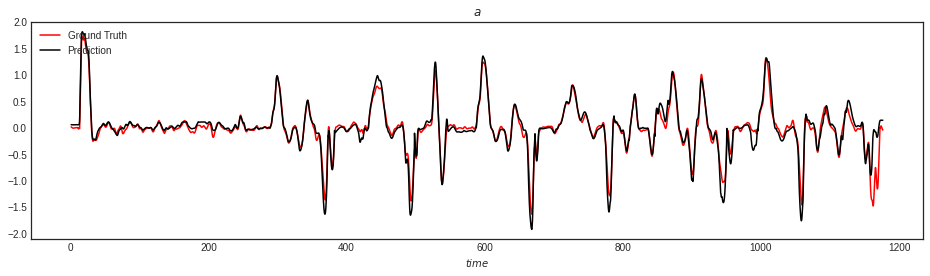

In [161]:
# Plotting 
true_acc = df_out['FOLLOW_ACC'].to_numpy()
pred_acc = df_out['Model forecast'].to_numpy()

fig, ax = plt.subplots(1) 

fig.set_figheight(4)
fig.set_figwidth(16)

g1, = ax.plot(t[:], true_acc, 'r')   # use v_p as well 
p1, = ax.plot(t[:], pred_acc, 'k')
ax.set_title('$a$')
ax.legend((g1, p1), ('Ground Truth', 'Prediction'), loc='upper left', shadow=False)
plt.xlabel("$time$")
#plt.savefig('ResearchUpdate#40/veryGoodModel1.png')
plt.show()

In [162]:
# save the model 
with open('../LSTMModels/ASTAZERO/LSTM_Stand_ASTA(S).pkl','wb') as f:
    pickle.dump(model,f)

Loading the model

In [31]:
# loading the model
with open('../LSTMModels/ASTAZERO/LSTM_Stand_ASTA(S).pkl', 'rb') as f:
    model = pickle.load(f)

# RMSE (S)

In [32]:
train_size = np.array(df_lstm_train).shape[0]
test_size = np.array(df_lstm_test).shape[0]

lstm_train_a = torch.zeros(train_size)   # contains unnormalized predictions 
lstm_train_v = torch.zeros(train_size)
lstm_train_pos = torch.zeros(train_size)
lstm_train_s = torch.zeros(train_size)

lstm_test_a = torch.zeros(test_size)
lstm_test_v = torch.zeros(test_size)
lstm_test_pos = torch.zeros(test_size)
lstm_test_s = torch.zeros(test_size)

lstm_train_a[0] = v_p[0]
lstm_train_v[0] = v[0]
lstm_train_pos[0] = followPos[0]
lstm_train_s[0] = s[0]

#lstm_test_a[0] = v_p[train_size]
#lstm_test_v[0] = v[train_size]
#lstm_test_pos[0] = followPos[train_size]
#lstm_test_s[0] = s[train_size]

def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    k = 0
    if data_loader == test_loader:
        lstm_test_a[0] = lstm_train_a[train_size-1]
        lstm_test_v[0] = lstm_train_v[train_size-1]
        lstm_test_pos[0] = lstm_train_pos[train_size-1]
        lstm_test_s[0] = lstm_train_s[train_size-1]
    with torch.no_grad():
        for X, _ in data_loader:
            if data_loader == train_eval_loader:
                if k != train_size-1:
                    #if k<3:
                    #    print(df_lstm_train.iloc[k])
                    y_star = model(X)                                                    
                    df_lstm_train.loc[k+1, 'HEADWAY'] = y_star.item()                    # Updating Dataframe
                    lstm_train_s[k+1] = y_star*target_stdev + target_mean                # Unnormalize POS
                    lstm_train_pos[k+1] = leadPos[k+1] - lstm_train_s[k+1] - leadLen[0]  # Calculating HEADWAY
                    lstm_train_v[k+1] = (lstm_train_pos[k+1]-lstm_train_pos[k]) / dt     # Caclulate VEL
                    if lstm_train_v[k+1]<0:
                        lstm_train_v[k+1] = 0   
                    h_star_norm = (lstm_train_v[k+1]-vel_mean) / vel_stdev               # Normalize VEL
                    df_lstm_train.loc[k+1, 'FOLLOW_VEL'] = h_star_norm.item()            # Updating Dataframe 
                    lstm_train_a[k+1] = (lstm_train_v[k+1]-lstm_train_v[k]) / dt         # Caclulate ACC
                    if lstm_train_a[k+1] < min_acc:
                        lstm_train_a[k+1] = min_acc
                    elif lstm_train_a[k+1] > max_acc:
                        lstm_train_a[k+1] = max_acc                        
                    #if k<3:
                    #    print(df_lstm_train.iloc[k+1])
            elif data_loader == test_loader:
                if k != test_size-1:
                    y_star = model(X)                                                    
                    df_lstm_test.loc[k+1, 'HEADWAY'] = y_star.item()                    # Updating Dataframe
                    lstm_test_s[k+1] = y_star*target_stdev + target_mean                # Unnormalize HDWY
                    lstm_test_pos[k+1] = leadPos[k+train_size] - lstm_test_s[k+1] - leadLen[0]  # Calculating POS
                    lstm_test_v[k+1] = (lstm_test_pos[k+1]-lstm_test_pos[k]) / dt     # Caclulate VEL
                    if lstm_train_v[k+1]<0:
                           lstm_train_v[k+1] = 0
                    h_star_norm = (lstm_test_v[k+1]-vel_mean) / vel_stdev               # Normalize VEL
                    df_lstm_test.loc[k+1, 'FOLLOW_VEL'] = h_star_norm.item()            # Updating Dataframe 
                    lstm_test_a[k+1] = (lstm_test_v[k+1]-lstm_test_v[k]) / dt         # Caclulate ACC
                    if lstm_test_a[k+1] < min_acc:
                        lstm_test_a[k+1] = min_acc
                    elif lstm_test_a[k+1] > max_acc:
                        lstm_test_a[k+1] = max_acc
            k += 1     
    return output

In [33]:
train_eval_dataset = SequenceDataset(
    df_lstm_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
train_eval_loader = DataLoader(train_eval_dataset, batch_size=1, shuffle=False) # shuffle=False

ystar_col = "Model_Forecast"
predict(train_eval_loader, model).numpy()
predict(test_loader, model).numpy()

array([], dtype=float32)

In [34]:
lstm_train_a_np = lstm_train_a.detach().cpu().numpy()
lstm_train_v_np = lstm_train_v.detach().cpu().numpy()
lstm_train_pos_np = lstm_train_pos.detach().cpu().numpy()
lstm_train_s_np = lstm_train_s.detach().cpu().numpy()

lstm_test_a_np = lstm_test_a.detach().cpu().numpy()
lstm_test_v_np = lstm_test_v.detach().cpu().numpy()
lstm_test_pos_np = lstm_test_pos.detach().cpu().numpy()
lstm_test_s_np = lstm_test_s.detach().cpu().numpy()

lstm_pred_a = np.concatenate((lstm_train_a_np, lstm_test_a_np))
lstm_pred_v = np.concatenate((lstm_train_v_np, lstm_test_v_np))
lstm_pred_pos = np.concatenate((lstm_train_pos_np, lstm_test_pos_np))
lstm_pred_s = np.concatenate((lstm_train_s_np, lstm_test_s_np))

In [35]:
# saving data in csv files 
allData = np.stack((lstm_pred_a, lstm_pred_v, lstm_pred_s, v_p, v, s), axis=1)
#np.savetxt('../../../Results/LSTM/Predictions/ASTAZERO/LSTM_Stand_ASTA(S).csv', allData, delimiter=',')

In [6]:
# loading predictions from csv files
my_data = genfromtxt('../../../Results/LSTM/Predictions/ASTAZERO/LSTM_Stand_ASTA(S).csv', delimiter=',')
lstm_pred_a = my_data[:,0]
lstm_pred_v = my_data[:,1]
lstm_pred_s = my_data[:,2]
v_p = my_data[:,3]
v = my_data[:,4]
s = my_data[:,5]

Train Acc. RMSE: 0.29894926470294186
Train Vel. RMSE 0.0682142657478278
Train Head. RMSE 0.024087888113525528
Test Acc. RMSE: 0.39390572004328395
Test Vel. RMSE 0.13877608377979864
Test Head. RMSE 0.07725579026269204


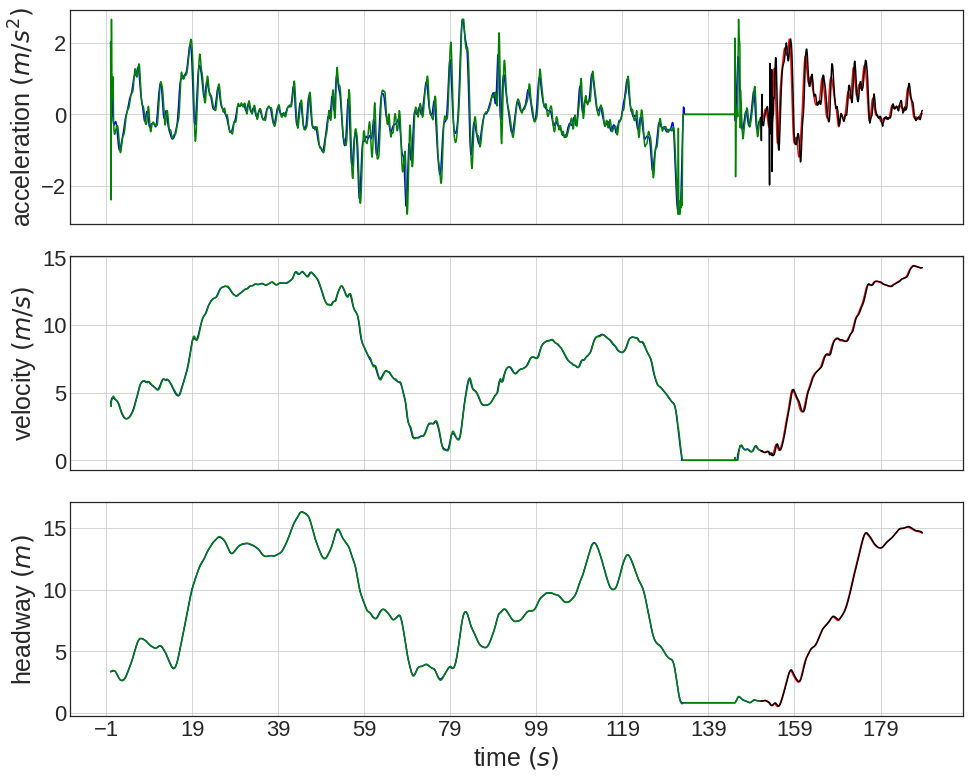

In [8]:
# Plotting 
en_Traj = 1511
acc_truth_plot = np.stack((v_p[en_Traj:],t[en_Traj:]), axis=1)
v_truth_plot = np.stack((v[en_Traj:],t[en_Traj:]), axis=1)
s_truth_plot = np.stack((s[en_Traj:],t[en_Traj:]), axis=1)

#lstm_pred = np.array(df_out['Model_Forecast'])

print('Train Acc. RMSE:', np.sqrt(mean_squared_error(lstm_pred_a[:en_Traj+1], v_p[:en_Traj+1])))
print("Train Vel. RMSE", np.sqrt(mean_squared_error(lstm_pred_v[:en_Traj+1], v[:en_Traj+1])))
print("Train Head. RMSE", np.sqrt(mean_squared_error(lstm_pred_s[:en_Traj+1], s[:en_Traj+1])))

print('Test Acc. RMSE:', np.sqrt(mean_squared_error(lstm_pred_a[en_Traj+1:], v_p[en_Traj+1:])))
print("Test Vel. RMSE", np.sqrt(mean_squared_error(lstm_pred_v[en_Traj+1:], v[en_Traj+1:])))
print("Test Head. RMSE", np.sqrt(mean_squared_error(lstm_pred_s[en_Traj+1:], s[en_Traj+1:])))

fig = plt.figure() 

gs = fig.add_gridspec(3, hspace=0.15)
ax = gs.subplots(sharex=True)

fig.set_figheight(13)
fig.set_figwidth(16)

plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=25)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=22)    # fontsize of the tick labels
plt.rc('ytick', labelsize=22)    # fontsize of the tick labels
plt.rc('legend', fontsize=22)    # legend fontsize
plt.rc('figure', titlesize=12)  # fontsize of the figure title

b1, = ax[0].plot(X_train[:,3], v_p[:en_Traj], "b")
g1, = ax[0].plot(X_prior[:en_Traj+1,3], lstm_pred_a[:en_Traj+1], "g")
r1, = ax[0].plot(acc_truth_plot[:,1], acc_truth_plot[:,0], "r")
k1, = ax[0].plot(X_prior[en_Traj+1:,3], lstm_pred_a[en_Traj+1:], "k")
ax[0].set_ylabel('acceleration $(m/s^2)$')
ax[0].grid(True)
ax[0].xaxis.set_ticks(np.arange(min(t), max(t), 20)-1)

ax[1].plot(X_train[:,3], X_train[:,0], "b")
ax[1].plot(X_prior[:en_Traj+1,3], lstm_pred_v[:en_Traj+1], "g")
ax[1].plot(v_truth_plot[:,1], v_truth_plot[:,0], "r")
ax[1].plot(X_prior[en_Traj+1:,3], lstm_pred_v[en_Traj+1:], "k")
ax[1].set_ylabel('velocity $(m/s)$')
ax[1].grid(True)

ax[2].plot(X_train[:,3], X_train[:,1], "b")
ax[2].plot(X_prior[:en_Traj+1,3], lstm_pred_s[:en_Traj+1], "g")
ax[2].plot(s_truth_plot[:,1], s_truth_plot[:,0], "r")
ax[2].plot(X_prior[en_Traj+1:,3], lstm_pred_s[en_Traj+1:], "k")
ax[2].set_ylabel('headway $(m)$')
ax[2].grid(True)
ax[2].set_xlabel('time $(s)$')

ax1.legend((b1, g1, r1, k1), ('Train Truth', 'Train Pred.', 'Test True', 'Test Pred.'), loc='upper left', shadow=False)

plt.savefig('../../../Results/LSTM/Plots/ASTAZERO/LSTM_Stand_ASTA(S).png')
plt.show()